In [1]:
import pandas as pd
import numpy as np
import time
import sys

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn import svm

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from integrating_embedding import *

import integrating_embedding
from imp import reload
reload(integrating_embedding)

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)

import get_hospital_eicu


emb_path_trn_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_train_new_version(0313).npy'
emb_path_vld_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_valid_new_version(0313).npy'
# emb_path_event_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_event_new_version(0310).npy'

emb_path_trn_eicu = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_eicu_new_version(0313).npy'

mimic_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/mimic_analysis(new_version0313).csv.gz'
eicu_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/eicu_analysis(new_version0313).csv.gz'

mimic_train_emb, mimic_valid_emb, event = integrating_embedding.integrating(mimic_path, emb_path_trn_mimic, emb_path_vld_mimic, _, 'mimic')
eicu_test_emb, event_eicu, hosp_id = integrating_embedding.integrating(eicu_path, emb_path_trn_eicu, _, _, 'eicu')
eicu_type = get_hospital_eicu.eicu_subgroup(eicu_test_emb)
unitadmitsource, unittype, unitstaytype = get_hospital_eicu.make_eicu_dataset(eicu_type)

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    174346
2.0     27608
3.0     70171
4.0     71699
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    17664
2.0     3030
3.0     9456
4.0     8278
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.51:0.08:0.20:0.21
테스트셋 클래스 비율: 0.46:0.08:0.25:0.22
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 5323
테스트셋 환자 수: 601
학습셋 체류 수: 5433
테스트셋 체류 수: 604
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.9
임계값: 0.1
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.26
시도한 시행 횟수: 0


In [3]:
module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)

import split
from imp import reload
reload(split)

import Multiclass_evaluation
reload(Multiclass_evaluation)

<module 'Multiclass_evaluation' from 'c:\\Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation\\Multiclass_evaluation.py'>

In [4]:
X_train, y_train, output = split.split_X_Y(mimic_train_emb, mode = 'mimic')
X_valid, y_valid, valid_output = split.split_X_Y(mimic_valid_emb, mode = 'mimic')

In [261]:
# use oversampling

# import oversampling
# reload(oversampling)
# X_resampled, y_resampled = oversampling.Synthetic_Minority_Oversampling_Tech(X_train, y_train)

--------------------
|Start Oversampling-SMOTE|
Before OverSampling, counts of case '1': 174346
Before OverSampling, counts of case '2': 27608
Before OverSampling, counts of case '3': 70171
Before OverSampling, counts of case '4': 71699
After OverSampling, the shape of train_X: (697384, 304)
After OverSampling, counts of case '1': 174346
After OverSampling, counts of case '2': 174346
After OverSampling, counts of case '3': 174346
After OverSampling, counts of case '4': 174346


In [263]:
reload(Multiclass_evaluation) #임베딩 + SMOTE
models_smote, result_smote = Multiclass_evaluation.create_analysis(event, X_resampled, y_resampled, X_valid, valid_output, mode = 'emb')

|MIMIC-Validation|====================================================


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC
0,xgb,0.910092,0.9524,0.9612,0.8418,0.7373,0.9351,0.9247,0.9452,0.9114
1,lgbm,0.912694,0.9542,0.9628,0.8514,0.7517,0.9370,0.9260,0.9454,0.9129
2,catboost,0.909597,0.9505,0.9607,0.8484,0.7338,0.9371,0.9266,0.9463,0.9136
3,rf,0.904549,0.9465,0.9595,0.8624,0.7315,0.9362,0.9232,0.9420,0.9100
4,dt,0.840507,0.9083,0.9326,0.7963,0.6214,0.9098,0.8736,0.8875,0.8516
5,svm-ovr,0.879645,0.9445,0.9583,0.8575,0.7227,0.8892,0.8839,0.9275,0.8686
6,lr,0.870563,0.9346,0.9539,0.8674,0.7157,0.8879,0.8835,0.9280,0.8683
7,naivebayes,0.094749,0.5000,0.7298,0.5339,0.5609,0.5082,0.2987,0.4977,0.1145
8,knn,0.572864,0.7594,0.8084,0.7422,0.5645,0.6780,0.5743,0.6339,0.4864


----------------------------------------------------------------------


In [6]:
col = list(X_train.columns[226:])

add_col = ['MAP', 'MAP_3hr_avg', 'Time_since_ICU_admission', 'cum_use_vaso', 'Lactate_clearance_1h', 'vasoactive/inotropic', 'Sodium_fillna', 'over_lactic', 'ethnicity', 'gender','Age',
           'Fluids(ml)', 'Lactate_clearance_7h', 'MAP_change_1h', 'Respiratory Rate_fillna', 'lactate_down', 'Lactate_clearance_9h', 'MAP_change_5h', 'pH_change_5h', 'suspected_infection', 'HR', 'Glucose', 'Lactate']

for adding in add_col:
    col.append(adding)

In [29]:
reload(Multiclass_evaluation) #임베딩 + baseline top 20
models, result = Multiclass_evaluation.create_analysis(event, X_train[col], y_train, X_valid[col], valid_output, mode = 'emb')

|MIMIC-Validation|====================================================


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC
0,xgb,0.915374,0.9582,0.9630,0.8285,0.7584,0.9361,0.9255,0.9455,0.9123
1,lgbm,0.916936,0.9592,0.9636,0.8294,0.7662,0.9377,0.9265,0.9456,0.9136
2,catboost,0.917170,0.9597,0.9638,0.8301,0.7659,0.9373,0.9262,0.9455,0.9132
3,rf,0.914724,0.9593,0.9626,0.8241,0.7676,0.9353,0.9230,0.9425,0.9097
4,dt,0.854039,0.9274,0.9425,0.7923,0.6452,0.9066,0.8677,0.8803,0.8439
5,svm-ovr,0.891277,0.9586,0.9627,0.8219,0.7616,0.8895,0.8835,0.9267,0.8681
6,lr,0.891902,0.9602,0.9628,0.8165,0.7689,0.8866,0.8831,0.9285,0.8680
7,naivebayes,0.689914,0.7761,0.8235,0.6490,0.5570,0.7819,0.7361,0.6407,0.6414
8,knn,0.757000,0.8768,0.8949,0.7533,0.6552,0.7918,0.7349,0.7790,0.6845


----------------------------------------------------------------------


In [14]:
result.drop('Accuracy', axis = 1).to_excel(excel_writer='internal_validation_proposed_method.xlsx')

In [31]:
result.drop('Accuracy', axis = 1).to_excel(excel_writer='internal_validation_proposed_method_compact_ver2.xlsx')

In [262]:
reload(Multiclass_evaluation) #임베딩 + baseline top 20 + SMOTE
models_smote_light, result_smote_light = Multiclass_evaluation.create_analysis(event, X_resampled[col], y_resampled, X_valid[col], valid_output, mode = 'emb')

|MIMIC-Validation|====================================================


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC
0,xgb,0.906422,0.9462,0.9600,0.8664,0.7354,0.9377,0.9270,0.9463,0.9141
1,lgbm,0.906891,0.9470,0.9609,0.8712,0.7426,0.9374,0.9263,0.9456,0.9133
2,catboost,0.908166,0.9484,0.9611,0.8676,0.7444,0.9373,0.9266,0.9461,0.9136
3,rf,0.901946,0.9437,0.9583,0.8639,0.7270,0.9357,0.9230,0.9422,0.9098
4,dt,0.845217,0.9125,0.9368,0.8144,0.6512,0.9081,0.8741,0.8908,0.8527
5,svm-ovr,0.863511,0.9260,0.9515,0.8792,0.7122,0.8890,0.8838,0.9275,0.8685
6,lr,0.865333,0.9285,0.9523,0.8772,0.7161,0.8865,0.8838,0.9295,0.8687
7,naivebayes,0.761034,0.8866,0.8982,0.6940,0.5680,0.8698,0.7927,0.6873,0.6830
8,knn,0.720126,0.8421,0.8796,0.8163,0.6564,0.7922,0.7300,0.7734,0.6759


----------------------------------------------------------------------


In [47]:
#optuna
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
import classifier_ML
reload(classifier_ML)

sampler = TPESampler(seed=10)

def objective(trial):
    
    param = {
        'objective': 'multiclass',
        'verbose': -1,
        'metric': 'multi_logloss', 
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        "num_class": 4,
        'max_depth': trial.suggest_int('max_depth',10, 300),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 9, 11),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),

    }


    model = LGBMClassifier(**param, early_stopping_rounds=25, random_state =42)
    lgb_model = model.fit(X_train[col], y_train, eval_set=[(X_valid[col], y_valid)])
    valid_preds = lgb_model.predict(X_valid[col])
    valid_output['prediction_label'] = valid_preds
    valid_output['prediction_prob'] = lgb_model.predict_proba(X_valid[col])[:, 1]
    
    result = Multiclass_evaluation.MULT_evaluation(valid_output, event, 'lgbm', 'mimic')
    
    return result['Case 2 AUPRC'].values[0]
        
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(objective, n_trials=30)
print('catboost Best parameters:', study_lgb.best_params)

[I 2024-03-14 13:32:39,885] A new study created in memory with name: no-name-666de290-3873-423b-bcce-b5baa029096a
[I 2024-03-14 13:32:41,369] Trial 0 finished with value: 0.7654 and parameters: {'extra_trees': True, 'class_weight': None, 'max_depth': 155, 'lambda_l1': 1.0547992438188775e-06, 'lambda_l2': 6.061300044367956e-07, 'n_estimators': 11, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 0 with value: 0.7654.
[I 2024-03-14 13:32:42,799] Trial 1 finished with value: 0.7638 and parameters: {'extra_trees': False, 'class_weight': None, 'max_depth': 246, 'lambda_l1': 0.003256376421394008, 'lambda_l2': 0.03131827670437561, 'n_estimators': 9, 'min_child_samples': 93, 'subsample': 0.7698715745641292}. Best is trial 0 with value: 0.7654.
[I 2024-03-14 13:32:44,244] Trial 2 finished with value: 0.764 and parameters: {'extra_trees': True, 'class_weight': None, 'max_depth': 138, 'lambda_l1': 8.056120247993029e-05, 'lambda_l2': 0.0036299680810414838, 'n_estimators': 1

catboost Best parameters: {'extra_trees': False, 'class_weight': None, 'max_depth': 165, 'lambda_l1': 0.18741711685770177, 'lambda_l2': 1.591938858585313e-06, 'n_estimators': 11, 'min_child_samples': 99, 'subsample': 0.5518970006865853}


In [7]:
reload(Multiclass_evaluation)

# lgbm_tune = LGBMClassifier(max_depth = 162, lambda_l1 =  6.43738960684482e-08, lambda_l2 = 0.5303400617756094,
#                            n_estimators = 11, min_child_samples = 54, subsample =   0.6215386045286333, extra_trees = True, verbose=-1, random_state =42)

#light
lgbm_tune = LGBMClassifier(max_depth = 165, lambda_l1 =  0.18741711685770177, lambda_l2 = 1.591938858585313e-06,
                           n_estimators = 11, min_child_samples = 99, subsample =  0.5518970006865853, extra_trees = False, verbose=-1, random_state =42)

lgbm_tune.fit(X_train[col], y_train)


valid_preds = lgbm_tune.predict(X_valid[col])
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob'] = lgbm_tune.predict_proba(X_valid[col])[:, 1]
    
result_validation = Multiclass_evaluation.MULT_evaluation(valid_output, event, 'lgbm', 'mimic')
print('Tuned evaluation')
display(result_validation)

result_external = Multiclass_evaluation.external_evaluation(unitadmitsource, unittype, unitstaytype, lgbm_tune, 'LightGBM', event_eicu, col)

Tuned evaluation


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC
0,lgbm,0.916884,0.9607,0.9625,0.8039,0.7718,0.9377,0.9249,0.9431,0.9119


[Starting eICU-Test]
eICU-UnitAdmitSource...
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
eICU-UnitType...
eICU-UnitStayType...
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError


Model  Accuracy  Case 1 AUROC  \
Subpopulation   eICU Type                                                
UnitAdmitSource Floor                 LightGBM  0.875071        0.8949   
                Emergency Department  LightGBM  0.855979        0.8781   
                Recovery Room         LightGBM  0.896458        0.9207   
                Direct Admit          LightGBM  0.836664        0.8628   
                Operating Room        LightGBM  0.845783        0.8750   
                Step-Down Unit (SDU)  LightGBM  0.835538        0.8608   
                Other ICU             LightGBM  0.882704        0.8917   
                Other Hospital        LightGBM  0.873480        0.8973   
                Acute Care/Floor      LightGBM  0.848870        0.8693   
                ICU                   LightGBM  0.925862        0.9028   
                PACU                  LightGBM  0.892330        0.8974   
                Observation           LightGBM  0.750000        0.7619   
                ICU to SDU            LightGBM  0.863636        0.8929   
UnitType        Med-Surg ICU          LightGBM  0.854844        0.8773   
                MICU                  LightGBM  0.853134        0.8746   
                Neuro ICU             LightGBM  0.862882        0.8855   
                Cardiac ICU           LightGBM  0.854666        0.8741   
                SICU                  LightGBM  0.880452        0.9055   
                CTICU                 LightGBM  0.834046        0.8713   
                CCU-CTICU             LightGBM  0.876095        0.8956   
                CSICU                 LightGBM  0.875973        0.8944   
UnitStayType    admit                 LightGBM  0.856700        0.8806   
                transfer              LightGBM  0.890188        0.9083   
                readmit               LightGBM  0.846612        0.8665   
                stepdown/other        LightGBM  0.863636        0.8929   

                                      Case 1 AUPRC  Case 2 AUROC  \
Subpopulation   eICU Type                                          
UnitAdmitSource Floor                       0.9335        0.7631   
                Emergency Department        0.9191        0.7559   
                Recovery Room               0.9407        0.8177   
                Direct Admit                0.9094        0.7279   
                Operating Room              0.9174        0.7819   
                Step-Down Unit (SDU)        0.9277        0.7065   
                Other ICU                   0.9596        0.7470   
                Other Hospital              0.9371        0.7565   
                Acute Care/Floor            0.9336        0.7443   
                ICU                         0.9756        0.7366   
                PACU                        0.9084        0.7463   
                Observation                 0.7393        1.0000   
                ICU to SDU                  0.9610        0.6250   
UnitType        Med-Surg ICU                0.9176        0.7593   
                MICU                        0.9230        0.7509   
                Neuro ICU                   0.9394        0.7253   
                Cardiac ICU                 0.9358        0.7404   
                SICU                        0.9282        0.7814   
                CTICU                       0.9494        0.7393   
                CCU-CTICU                   0.9347        0.7674   
                CSICU                       0.9407        0.7640   
UnitStayType    admit                       0.9240        0.7613   
                transfer                    0.9448        0.7638   
                readmit                     0.9306        0.6888   
                stepdown/other              0.9610        0.6250   

                                      Case 2 AUPRC Case 3 AUROC Case 3 AUPRC  \
Subpopulation   eICU Type                                                      
UnitAdmitSource Floor                       0

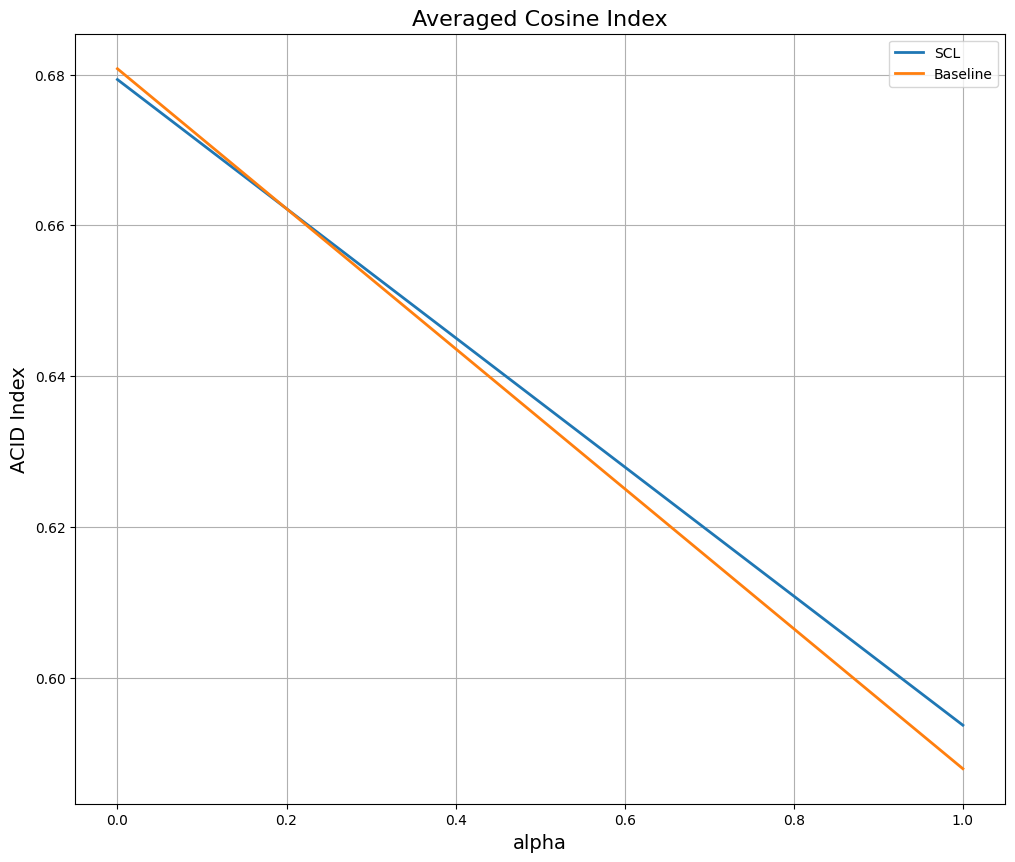

In [213]:
# import numpy as np
# import matplotlib.pyplot as plt
# cosine = 0.6807683848008791
# ea = 0.09285236330397509

# alpha_values = np.linspace(0, 1, 100)

# # acid_index 계산
# acid_index_scl = cosine_scl - alpha_values * ea_scl
# acid_index_bsl = cosine - alpha_values * ea

# # 시각화
# plt.figure(figsize=(12, 10))
# plt.plot(alpha_values, acid_index_scl, linewidth=2, label='SCL')
# plt.plot(alpha_values, acid_index_bsl, linewidth=2, label='Baseline')
# plt.title('Averaged Cosine Index', fontsize=16)
# plt.xlabel('alpha', fontsize=14)
# plt.ylabel('ACID Index', fontsize=14)
# plt.grid(True)
# plt.legend()
# plt.show()

In [50]:
result_external.to_excel(excel_writer='external_validation_proposed_method.xlsx')

In [45]:
# 만약 proposed method를 통해 type 별 분석시 인사이트가 없다면 그냥
# 그냥 eicu 전체에 대해서 평가
reload(split)
X_test, y_test, test_output = split.split_X_Y(eicu_test_emb, mode = 'eicu')

test_preds = lgbm_tune.predict(X_test[col])
test_output['prediction_label'] = test_preds
test_output['prediction_prob'] = lgbm_tune.predict_proba(X_test[col])[:, 1]

test_eval = Multiclass_evaluation.MULT_evaluation(test_output, event_eicu, 'lgbm', 'eicu')
print('Test evaluation')
display(test_eval)

Test evaluation


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC
0,lgbm,0.859698,0.883,0.9268,0.7578,0.5537,0.8964,0.8466,0.9783,0.9699


In [46]:
cosine, alpha = Multiclass_evaluation.ACID(test_output, event_eicu, 'eicu')

In [200]:
cosine

0.7257040405102958

In [201]:
alpha

0.19778515739479005

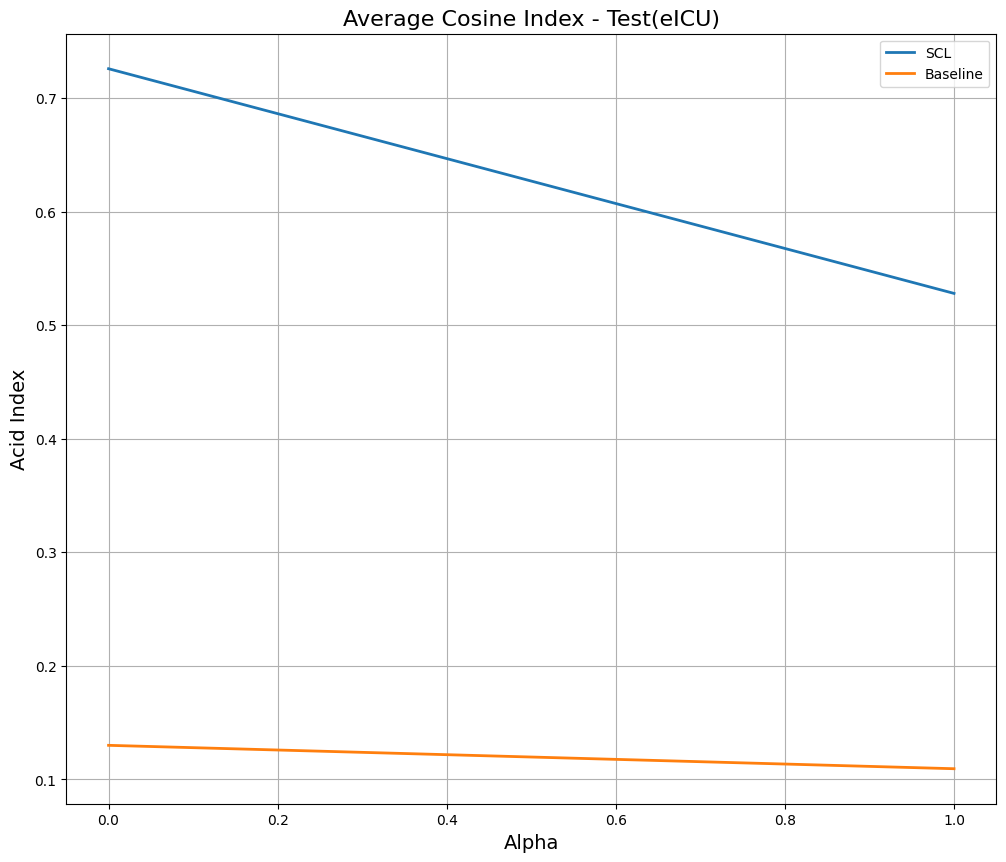

In [47]:
import numpy as np
import matplotlib.pyplot as plt

SCL_cosine = cosine  
SCL_ea = alpha      

baseline_cosine = 0.13007574041043446  
baseline_ea = 0.020593650440416594        

alpha_values = np.linspace(0, 1, 100)

# acid_index 계산
acid_index = SCL_cosine - alpha_values * SCL_ea
acid_index_baseline = baseline_cosine - alpha_values * baseline_ea

# 시각화
plt.figure(figsize=(12, 10))
plt.plot(alpha_values, acid_index, markersize=5, linewidth=2, label='SCL')
plt.plot(alpha_values, acid_index_baseline, markersize=5, linewidth=2, label='Baseline')
plt.title('Average Cosine Index - Test(eICU)', fontsize=16)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Acid Index', fontsize=14) 
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# class 갯수가 많은 애들은 contrastive 쓰나 마나 똑같음 -> 원본데이터로도 충분히 정보가 있음
# 하지만 contrastive 를 씀으로써 맞추기 힘든 case 2를 잘 맞출 수 있게 됨 -> 모든 모델에서 모두 상승함
# contastive learning이 데이터 불균형 상황이더라도, 소수 클래스에 대해서 적합을 잘할 수 있음

# 이를 바탕으로 쇼크 모니터링 시스템을 개발함
# 베스 이스라엘 뿐 아니라, 다른 다양한 병원에서도 잘 적합하는 시스템을 개발하기 위해 본 연구에서는 eicu 데이터를 활용
# 따라서 eicu 2014를 이용해 시스템을 개발하고, 성능 평가를 위해 2015 데이터를 활용
# 가장 성능이 좋았던 모델을 기반으로 시스템을 개발

### Naive System Recall & Tracking system

In [8]:
#tracking system
reload(split)


X_viz, y_train_viz, output_viz = split.split_X_Y_for_VIZ(mimic_train_emb, mode = 'mimic')
X_valid_viz, y_train_valid_viz, output_valid_viz = split.split_X_Y_for_VIZ(mimic_valid_emb, mode = 'mimic')
X_test_viz, y_test_viz, test_output_viz = split.split_X_Y_for_VIZ(eicu_test_emb, mode = 'eicu')

lgbm_tune = LGBMClassifier(max_depth = 165, lambda_l1 =  0.18741711685770177, lambda_l2 = 1.591938858585313e-06,
                           n_estimators = 11, min_child_samples = 99, subsample =  0.5518970006865853, extra_trees = False, verbose=-1, random_state =42)

lgbm_tune.fit(X_viz[col], y_train_viz)

preds = lgbm_tune.predict(X_viz[col])
output_viz['prediction_label'] = preds
output_viz['prediction_prob_case2'] = lgbm_tune.predict_proba(X_viz[col])[:, 1]
output_viz['prediction_prob_case3'] = lgbm_tune.predict_proba(X_viz[col])[:, 2]
output_viz['prediction_prob_case4'] = lgbm_tune.predict_proba(X_viz[col])[:, 3]

preds = lgbm_tune.predict(X_valid_viz[col])
output_valid_viz['prediction_label'] = preds
output_valid_viz['prediction_prob_case2'] = lgbm_tune.predict_proba(X_valid_viz[col])[:, 1]
output_valid_viz['prediction_prob_case3'] = lgbm_tune.predict_proba(X_valid_viz[col])[:, 2]
output_valid_viz['prediction_prob_case4'] = lgbm_tune.predict_proba(X_valid_viz[col])[:, 3]

test_preds = lgbm_tune.predict(X_test_viz[col])
test_output_viz['prediction_label'] = test_preds
test_output_viz['prediction_prob_case2'] = lgbm_tune.predict_proba(X_test_viz[col])[:, 1]
test_output_viz['prediction_prob_case3'] = lgbm_tune.predict_proba(X_test_viz[col])[:, 2]
test_output_viz['prediction_prob_case4'] = lgbm_tune.predict_proba(X_test_viz[col])[:, 3]

In [9]:
event_cohort_viz = output_viz[output_viz.stay_id.isin(event.stay_id.unique())]
event_cohort_eval = output_valid_viz[output_valid_viz.stay_id.isin(event.stay_id.unique())]
event_cohort_test = test_output_viz[test_output_viz.patientunitstayid.isin(event_eicu.patientunitstayid.unique())]

In [10]:
mimic_origin = pd.read_csv(mimic_path, compression = 'gzip')
eicu_origin = pd.read_csv(eicu_path, compression='gzip')

recovery = mimic_origin[(mimic_origin['INDEX']=='CASE3_CASE4_DF')&(mimic_origin['Annotation']=='no_circ')]
recovery_eval = event_cohort_eval[event_cohort_eval['stay_id'].isin(recovery.stay_id.unique())].sort_values(by=['stay_id', 'Time_since_ICU_admission'])
no_recovery_eval = event_cohort_eval[~event_cohort_eval['stay_id'].isin(recovery.stay_id.unique())].sort_values(by=['stay_id', 'Time_since_ICU_admission'])

recovery_e = eicu_origin[(eicu_origin['INDEX']=='CASE3_CASE4_DF')&(eicu_origin['Annotation']=='no_circ')]
recovery_test = event_cohort_test[event_cohort_test['patientunitstayid'].isin(recovery_e.patientunitstayid.unique())].sort_values(by=['patientunitstayid', 'Time_since_ICU_admission'])
no_recovery_test = event_cohort_test[~event_cohort_test['patientunitstayid'].isin(recovery_e.patientunitstayid.unique())].sort_values(by=['patientunitstayid', 'Time_since_ICU_admission'])

In [193]:
def NSA(recover, no_recover, mode):
    
    recover_df = recover.copy()
    no_recover_df = no_recover.copy()
    
    
    if mode == 'mimic':
        stay_id_id = 'stay_id'
    else:
        stay_id_id ='patientunitstayid'
        
    recover_set = []

    for idx, stay in enumerate(recover_df[stay_id_id].unique()):
        interest = recover_df[recover_df[stay_id_id]==stay]
        before_shock = interest[interest['after_shock_annotation']=='before_experience_shock']
        before_shock['Case'] = before_shock['Case'].replace({1:0, 2:1})
        before_shock['prediction_label'] = before_shock['prediction_label'].replace({1:0, 2:1})

        if before_shock[before_shock['Case']==1]['prediction_label'].sum() >= 1:
            before_shock_score = 1
        else:
            before_shock_score = 0

        #---------------------------------------------------------------------------------------------
        interest = recover_df[recover_df[stay_id_id]==stay]
        after_shock = interest.iloc[[-1]]
        after_shock['Case'] = after_shock['Case'].replace({3:1, 4:0})
        after_shock['prediction_label'] = after_shock['prediction_label'].replace({3:1, 4:0})

        after_shock_score = recall_score(after_shock['Case'], after_shock['prediction_label'])
        #---------------------------------------------------------------------------------------------

        nsa = (0.7*np.array(before_shock_score).mean() + 0.3*np.array(after_shock_score).mean())
        recover_set.append(nsa)
        
    no_recover_set = []

    for stay in no_recover_df[stay_id_id].unique():
        
        interest = no_recover_df[no_recover_df[stay_id_id]==stay]
        before_shock = interest[interest['after_shock_annotation']=='before_experience_shock']
        before_shock['Case'] = before_shock['Case'].replace({1:0, 2:1})
        before_shock['prediction_label'] = before_shock['prediction_label'].replace({1:0, 2:1})

        if before_shock[before_shock['Case']==1]['prediction_label'].sum() >= 1:
            before_shock_score = 1
        else:
            before_shock_score = 0

        #---------------------------------------------------------------------------------------------
        interest = no_recover_df[no_recover_df[stay_id_id]==stay]
        after_shock = interest.iloc[[-1]]
        after_shock['Case'] = after_shock['Case'].replace({3:0, 4:1})
        after_shock['prediction_label'] = after_shock['prediction_label'].replace({3:0, 4:1})

        after_shock_score = recall_score(after_shock['Case'], after_shock['prediction_label'])
        #---------------------------------------------------------------------------------------------

        nsa = (0.7*np.array(before_shock_score).mean() + 0.3*np.array(after_shock_score).mean())
        no_recover_set.append(nsa)
    nsa = (np.array(recover_set).mean() + np.array(no_recover_set).mean())/2
    return nsa

val_nsa = NSA(recovery_eval, no_recovery_eval, 'mimic')
test_nsa = NSA(recovery_test, no_recovery_test, 'eicu')

In [190]:
def NSA_Curve(recover, no_recover, mode):
    
    recover_df = recover.copy()
    no_recover_df = no_recover.copy()
    
    thresholds = np.linspace(0, 1, 21)
    threshold_by_score = []
    
    if mode == 'mimic':
        stay_id_id = 'stay_id'
    else:
        stay_id_id ='patientunitstayid'
    
    for th in thresholds:    
        recover_set = []

        for idx, stay in enumerate(recover_df[stay_id_id].unique()):
            interest = recover_df[recover_df[stay_id_id]==stay]
            before_shock = interest[interest['after_shock_annotation']=='before_experience_shock']
            before_shock['Case'] = before_shock['Case'].replace({1:0, 2:1})
            before_shock['prediction_label'] = before_shock['prediction_label'].replace({1:0, 2:1})
            
            before_shock['prediction_label'] = np.where(before_shock['prediction_prob_case2'] >= th, before_shock['Case'], 0)

            if before_shock[before_shock['Case']==1]['prediction_label'].sum() >= 1:
                before_shock_score = 1
            else:
                before_shock_score = 0

            #---------------------------------------------------------------------------------------------
            interest = recover_df[recover_df[stay_id_id]==stay]
            after_shock = interest.iloc[[-1]]
            after_shock['Case'] = after_shock['Case'].replace({3:1, 4:0})
            after_shock['prediction_label'] = after_shock['prediction_label'].replace({3:1, 4:0})

            before_shock['prediction_label'] = np.where(before_shock['prediction_prob_case3'] >= th, before_shock['Case'], 0)
            
            after_shock_score = recall_score(after_shock['Case'], after_shock['prediction_label'])
            #---------------------------------------------------------------------------------------------

            nsa = (0.7*np.array(before_shock_score).mean() + 0.3*np.array(after_shock_score).mean())
            recover_set.append(nsa)
            
        no_recover_set = []

        for stay in no_recover_df[stay_id_id].unique():
            
            interest = no_recover_df[no_recover_df[stay_id_id]==stay]
            before_shock = interest[interest['after_shock_annotation']=='before_experience_shock']
            before_shock['Case'] = before_shock['Case'].replace({1:0, 2:1})
            before_shock['prediction_label'] = before_shock['prediction_label'].replace({1:0, 2:1})

            before_shock['prediction_label'] = np.where(before_shock['prediction_prob_case2'] >= th, before_shock['Case'], 0)
            
            if before_shock[before_shock['Case']==1]['prediction_label'].sum() >= 1:
                before_shock_score = 1
            else:
                before_shock_score = 0

            #---------------------------------------------------------------------------------------------
            interest = no_recover_df[no_recover_df[stay_id_id]==stay]
            after_shock = interest.iloc[[-1]]
            after_shock['Case'] = after_shock['Case'].replace({3:0, 4:1})
            after_shock['prediction_label'] = after_shock['prediction_label'].replace({3:0, 4:1})
            before_shock['prediction_label'] = np.where(before_shock['prediction_prob_case4'] >= th, before_shock['Case'], 0)
            after_shock_score = recall_score(after_shock['Case'], after_shock['prediction_label'])
            #---------------------------------------------------------------------------------------------

            nsa = (0.7*np.array(before_shock_score).mean() + 0.3*np.array(after_shock_score).mean())
            no_recover_set.append(nsa)
        nsa = (np.array(recover_set).mean() + np.array(no_recover_set).mean())/2
        threshold_by_score.append(nsa)
    return threshold_by_score

threshold_by_score_val = NSA_Curve(recovery_eval, no_recovery_eval, 'mimic')
threshold_by_score_test = NSA_Curve(recovery_test, no_recovery_test, 'eicu')

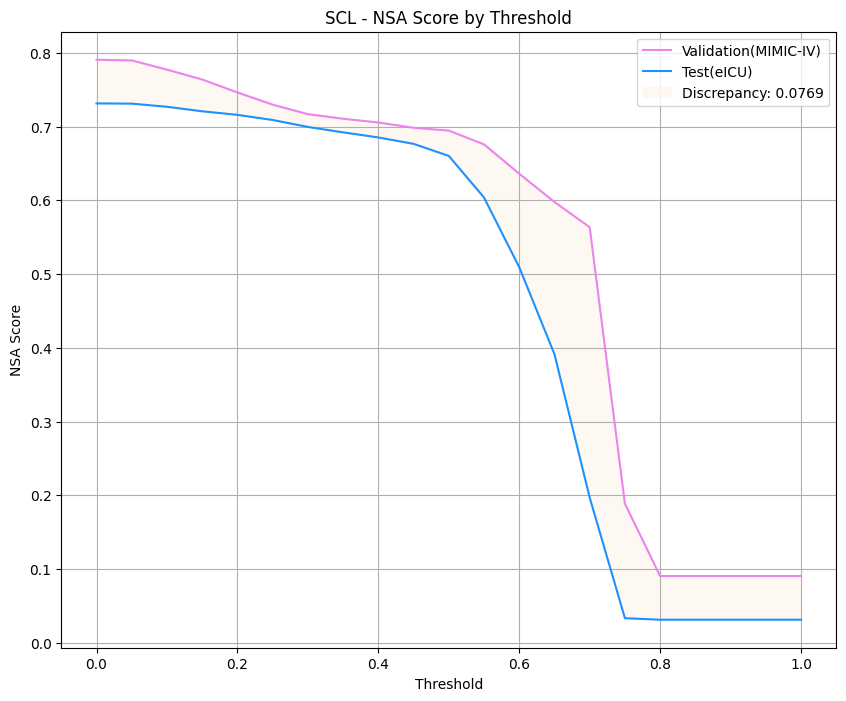

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
thresholds = np.linspace(0, 1, 21)

plt.figure(figsize=(10, 8))
plt.plot(thresholds, threshold_by_score_val, label = 'Validation(MIMIC-IV)', color='violet')
plt.plot(thresholds, threshold_by_score_test, label = 'Test(eICU)', color='dodgerblue')

area = np.trapz(np.abs(np.array(threshold_by_score_val) - np.array(threshold_by_score_test)), thresholds)
plt.fill_between(thresholds, threshold_by_score_val, threshold_by_score_test, color='oldlace', alpha=0.5, label = 'Discrepancy: {}'.format(np.round(area,4)))
plt.title('SCL - NSA Score by Threshold')
plt.xlabel('Threshold')
plt.ylabel('NSA Score')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import classification_report

In [12]:
def min_max_scaling(column, min_value, max_value):
    
    if (min_value == 'none') & (max_value == 'none'):
        min_value = column.min()
        max_value = column.max()
        scaled_column = (column - min_value) / (max_value - min_value + 0.0000000001)
        return scaled_column, min_value, max_value
    
    else:
        scaled_column = (column - min_value) / (max_value - min_value + 0.0000000001)
        return scaled_column

In [351]:
eicu_path_pre = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Make Derived Variable/eicu_df_cp.csv.gz'
eicu_pre = pd.read_csv(eicu_path_pre, compression = 'gzip')

In [13]:
mimic_path_pre = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Make Derived Variable/mimic_df_cp.csv.gz'
mimic_pre = pd.read_csv(mimic_path_pre, compression = 'gzip')

In [14]:
# eicu
# 17 -> 우선 순위로 해볼 정도로 굿
# 23 굿

recovery_set = output_viz[output_viz['stay_id'].isin(recovery.stay_id.unique())].sort_values(by=['stay_id', 'Time_since_ICU_admission'])
no_recovery_set = output_viz[~output_viz['stay_id'].isin(recovery.stay_id.unique())].sort_values(by=['stay_id', 'Time_since_ICU_admission'])

In [15]:
f1_scores = {}

# 유니크한 stay_id 별로 반복
for stay_id in recovery_set['stay_id'].unique():
    interest = recovery_set[recovery_set['stay_id'] == stay_id]
    report = classification_report(interest.Case, interest.prediction_label, output_dict=True)
    report_int_keys = {int(float(k)): v for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}
    if 3 in interest.Case.values:
        case34_f1 = np.round(report_int_keys[3]['f1-score'], 4) if 3 in report_int_keys else np.nan
    else:
        case34_f1 = np.nan
        
    if 2 in interest.Case.values:
        case2_f1 = np.round(report_int_keys[2]['f1-score'], 4) if 2 in report_int_keys else np.nan
    else:
        case2_f1 = np.nan

    f1_scores[stay_id] = (case34_f1 + case2_f1) / 2

monitoring_recovery_id = [stay_id for stay_id, f1 in f1_scores.items() if f1 >= 0.9]

f1_scores = {}

# 유니크한 stay_id 별로 반복
for stay_id in no_recovery_set['stay_id'].unique():
    interest = no_recovery_set[no_recovery_set['stay_id'] == stay_id]
    report = classification_report(interest.Case, interest.prediction_label, output_dict=True)
    report_int_keys = {int(float(k)): v for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}
    if 3 in interest.Case.values:
        case34_f1 = np.round(report_int_keys[3]['f1-score'], 4) if 3 in report_int_keys else np.nan
    else:
        case34_f1 = np.nan
        
    if 2 in interest.Case.values:
        case2_f1 = np.round(report_int_keys[2]['f1-score'], 4) if 2 in report_int_keys else np.nan
    else:
        case2_f1 = np.nan

    f1_scores[stay_id] = (case34_f1 + case2_f1) / 2

monitoring_no_recovery_id = [stay_id for stay_id, f1 in f1_scores.items() if f1 >= 0.7]

In [16]:
viz_id = []

for stay in monitoring_recovery_id:

    sample = recovery_set[recovery_set['stay_id'] == stay]
    
    # if all(sample[sample['INDEX']=='CASE1_CASE2_DF']['Annotation']=='no_circ'):
    #     viz_id.append(stay)
        
    if len(sample[sample['INDEX']=='CASE1_CASE2_DF']) > 8 and all(sample[sample['INDEX']=='CASE1_CASE2_DF'].head(6)['prediction_prob_case2']<0.6):
        viz_id.append(stay)

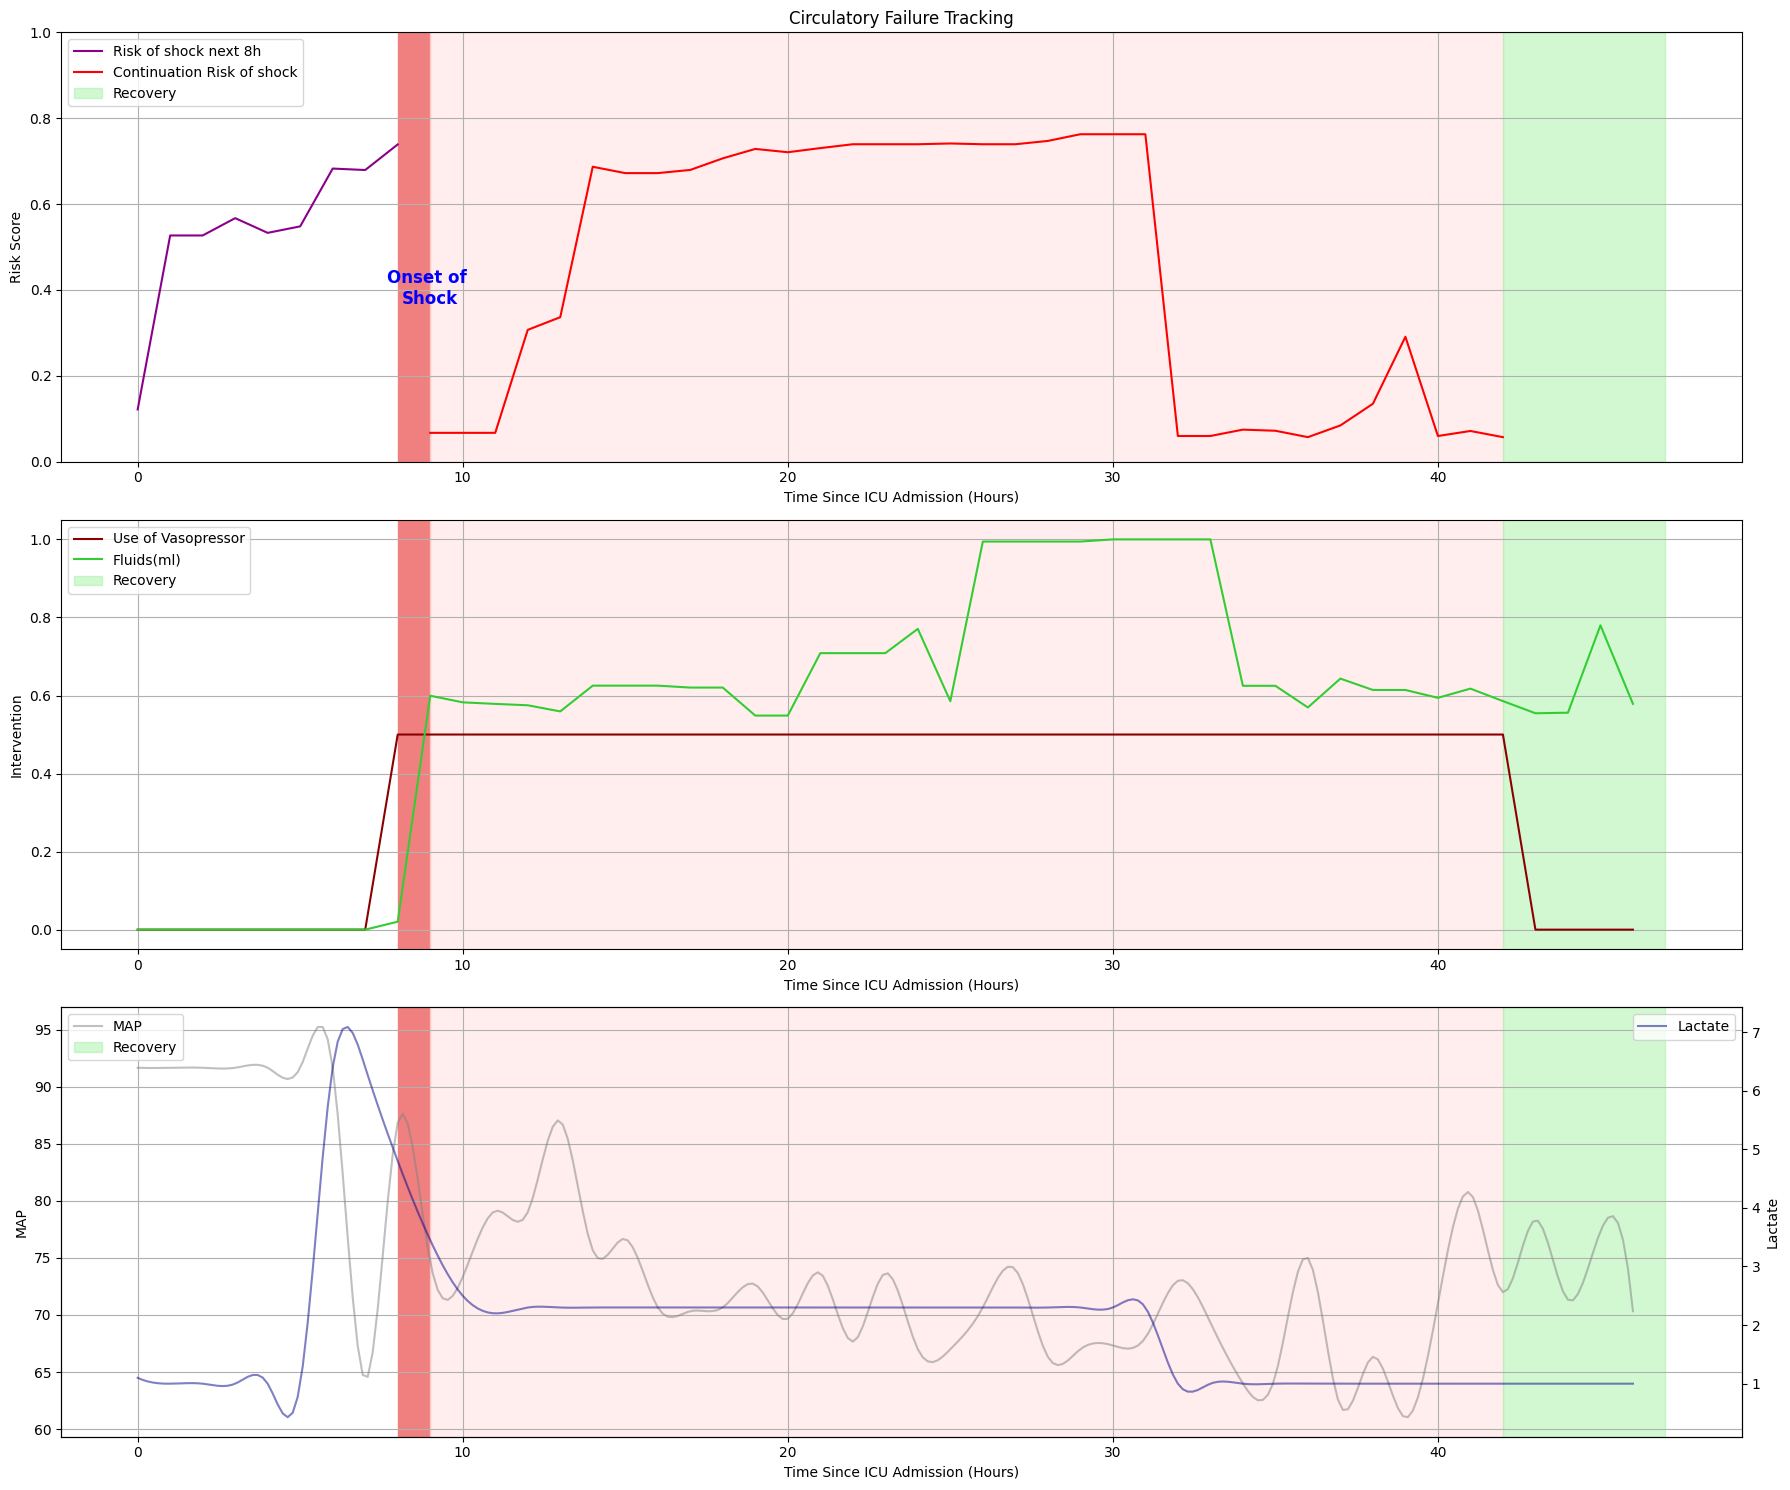

In [37]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
# 4, "6(33965130)", "13(38132467)"
sec = 13

interest = recovery_set[recovery_set['stay_id'] == viz_id[sec]].reset_index(drop=True)

interest['Fluids(ml)_scaled'], fluids_min, fluids_max = min_max_scaling(interest['Fluids(ml)'], 'none', 'none')
interest['Lactate_scaled'], lactate_min, lactate_max = min_max_scaling(interest['Lactate'], 'none', 'none')
interest['MAP_scaled'], map_min, map_max = min_max_scaling(interest['MAP'], 'none', 'none')

event_index = interest[interest['after_shock_annotation']=='before_experience_shock'].index[-1]

Case1_2 = interest.iloc[:event_index+1]
Case3_4 = interest.iloc[event_index+1:]
Case3_4 = Case3_4.drop_duplicates(subset=['Time_since_ICU_admission'])

onset_of_shock_time = Case3_4['Time_since_ICU_admission'].iloc[0]
end_of_shock_time = Case3_4['Time_since_ICU_admission'].iloc[-1]

# out_of_analysis = eicu_pre[eicu_pre['patientunitstayid'] == viz_id[sec]][['Time_since_ICU_admission', 'MAP', 'Lactate', 'vasoactive/inotropic', 'Fluids(ml)']]
out_of_analysis = mimic_pre[mimic_pre['stay_id'] == viz_id[sec]][['Time_since_ICU_admission', 'MAP', 'Lactate', 'vasoactive/inotropic', 'Fluids(ml)']]
view = out_of_analysis[(out_of_analysis['Time_since_ICU_admission'] > end_of_shock_time) & (out_of_analysis['Time_since_ICU_admission'] < end_of_shock_time+5)]

view['Fluids(ml)_scaled'] = min_max_scaling(view['Fluids(ml)'], fluids_min, fluids_max)
view['Lactate_scaled'] = min_max_scaling(view['Lactate'],lactate_min, lactate_max)
view['MAP_scaled'] = min_max_scaling(view['MAP'],  map_min, map_max)

# plt.figure(figsize=(18, 15))
# plt.subplot(3, 1, 1)
fig, ax1 = plt.subplots(3, 1, figsize=(18, 15)) 

# Case1_2
ax1[0].plot(Case1_2['Time_since_ICU_admission'], Case1_2['prediction_prob_case2'], linestyle='-', color='darkmagenta', label='Risk of shock next 8h')
# Case3_4
ax1[0].plot(Case3_4['Time_since_ICU_admission'], Case3_4['prediction_prob_case4'], linestyle='-', color='red', label='Continuation Risk of shock')

ax1[0].axvspan(onset_of_shock_time-1, onset_of_shock_time, color='lightcoral')
ax1[0].axvspan(onset_of_shock_time, end_of_shock_time, color='mistyrose', alpha=0.6)
ax1[0].axvspan(end_of_shock_time, end_of_shock_time+5, color='lightgreen', alpha=0.4, label = 'Recovery')
# Onset of shock
ax1[0].text(onset_of_shock_time, 0.5 * (Case1_2['prediction_prob_case2'].iloc[-1] + Case3_4['prediction_prob_case4'].iloc[0]), 'Onset of \nShock', ha='center', va='center', fontsize=12, color='blue', fontweight='bold')

# xmin, xmax = 0, interest['Time_since_ICU_admission'].iloc[-1]  
# plt.xticks(range(xmin, xmax + 1, 4))
ymin, ymax = 0, 1 
ax1[0].set_yticks(np.arange(ymin, ymax + 0.1, 0.2))

ax1[0].set_title('Circulatory Failure Tracking')
ax1[0].set_xlabel('Time Since ICU Admission (Hours)')
ax1[0].set_ylabel('Risk Score')
ax1[0].grid(True)
ax1[0].legend(loc = 'upper left')

# Intervention ----------------------------------------------------------------------------------------------------

# fig, ax1 = plt.subplots(3, 1, figsize=(10, 15)) 

vital_lab = pd.concat([interest[view.columns], view.reset_index(drop=True)], axis = 0, ignore_index=True).drop_duplicates(subset=['Time_since_ICU_admission']).sort_values(by=['Time_since_ICU_admission'])

# Case1_2
ax1[1].plot(vital_lab['Time_since_ICU_admission'], (vital_lab['vasoactive/inotropic']/2), linestyle='-', color='darkred', label='Use of Vasopressor')
# Case3_4
ax1[1].plot(vital_lab['Time_since_ICU_admission'], vital_lab['Fluids(ml)_scaled'], linestyle='-', color='limegreen', label='Fluids(ml)')


ax1[1].axvspan(onset_of_shock_time-1, onset_of_shock_time, color='lightcoral')
ax1[1].axvspan(onset_of_shock_time, end_of_shock_time, color='mistyrose', alpha=0.6)
ax1[1].axvspan(end_of_shock_time, end_of_shock_time+5, color='lightgreen', alpha=0.4, label = 'Recovery')

ax1[1].set_ylabel('Intervention')
ax1[1].set_xlabel('Time Since ICU Admission (Hours)')
ax1[1].grid(True)
ax1[1].legend(loc = 'upper left')

# Vital sign & Lab test--------------------------------------------------------------------------------------------

# fig, ax1 = plt.subplots(3, 1, figsize=(18, 15))
vital_lab = pd.concat([interest[view.columns], view.reset_index(drop=True)], axis = 0, ignore_index=True).drop_duplicates(subset=['Time_since_ICU_admission']).sort_values(by=['Time_since_ICU_admission'])

MAP_before_shock = np.linspace(vital_lab['Time_since_ICU_admission'].min(), vital_lab['Time_since_ICU_admission'].max(), 300) 
spl = make_interp_spline(vital_lab['Time_since_ICU_admission'].values, vital_lab['MAP'].values, k=3) 
power_smooth_map_bs = spl(MAP_before_shock)

Lactate_before_shock = np.linspace(vital_lab['Time_since_ICU_admission'].min(), vital_lab['Time_since_ICU_admission'].max(), 300) 
spl = make_interp_spline(vital_lab['Time_since_ICU_admission'].values, vital_lab['Lactate'].values, k=3) 
power_smooth_lactate_bs = spl(Lactate_before_shock)

ax2 = ax1[2].twinx()  # 이중 y축 생성

# MAP 데이터 플로팅
ax1[2].plot(MAP_before_shock, power_smooth_map_bs, linestyle='-', color='gray', label='MAP', alpha=0.5)
ax1[2].set_ylabel('MAP', color='Black')
ax1[2].tick_params(axis='y', labelcolor='Black')  # 변경: axis 지정 방식

# Lactate 데이터 플로팅
ax2.plot(Lactate_before_shock, power_smooth_lactate_bs, linestyle='-', color='darkblue', label='Lactate', alpha=0.5)
ax2.set_ylabel('Lactate', color='Black')
ax2.tick_params(axis='y', labelcolor='Black')  # 변경: axis 지정 방식

# 충격과 회복 기간 표시
ax1[2].axvspan(onset_of_shock_time-1, onset_of_shock_time, color='lightcoral')
ax1[2].axvspan(onset_of_shock_time, end_of_shock_time, color='mistyrose', alpha=0.6)
ax1[2].axvspan(end_of_shock_time, end_of_shock_time+5, color='lightgreen', alpha=0.4, label='Recovery')

ax1[2].set_xlabel('Time Since ICU Admission (Hours)')
ax1[2].grid(True)
ax1[2].legend(loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()

In [19]:
no_viz_id = []

for stay in monitoring_no_recovery_id:

    sample = no_recovery_set[no_recovery_set['stay_id'] == stay]
    
    # if all(sample[sample['INDEX']=='CASE1_CASE2_DF']['Annotation']=='no_circ'):
    #     no_viz_id.append(stay)
        
    if len(sample[sample['INDEX']=='CASE1_CASE2_DF']) > 8 and all(sample[sample['INDEX']=='CASE1_CASE2_DF'].head(6)['prediction_prob_case2']<0.6):
        no_viz_id.append(stay)

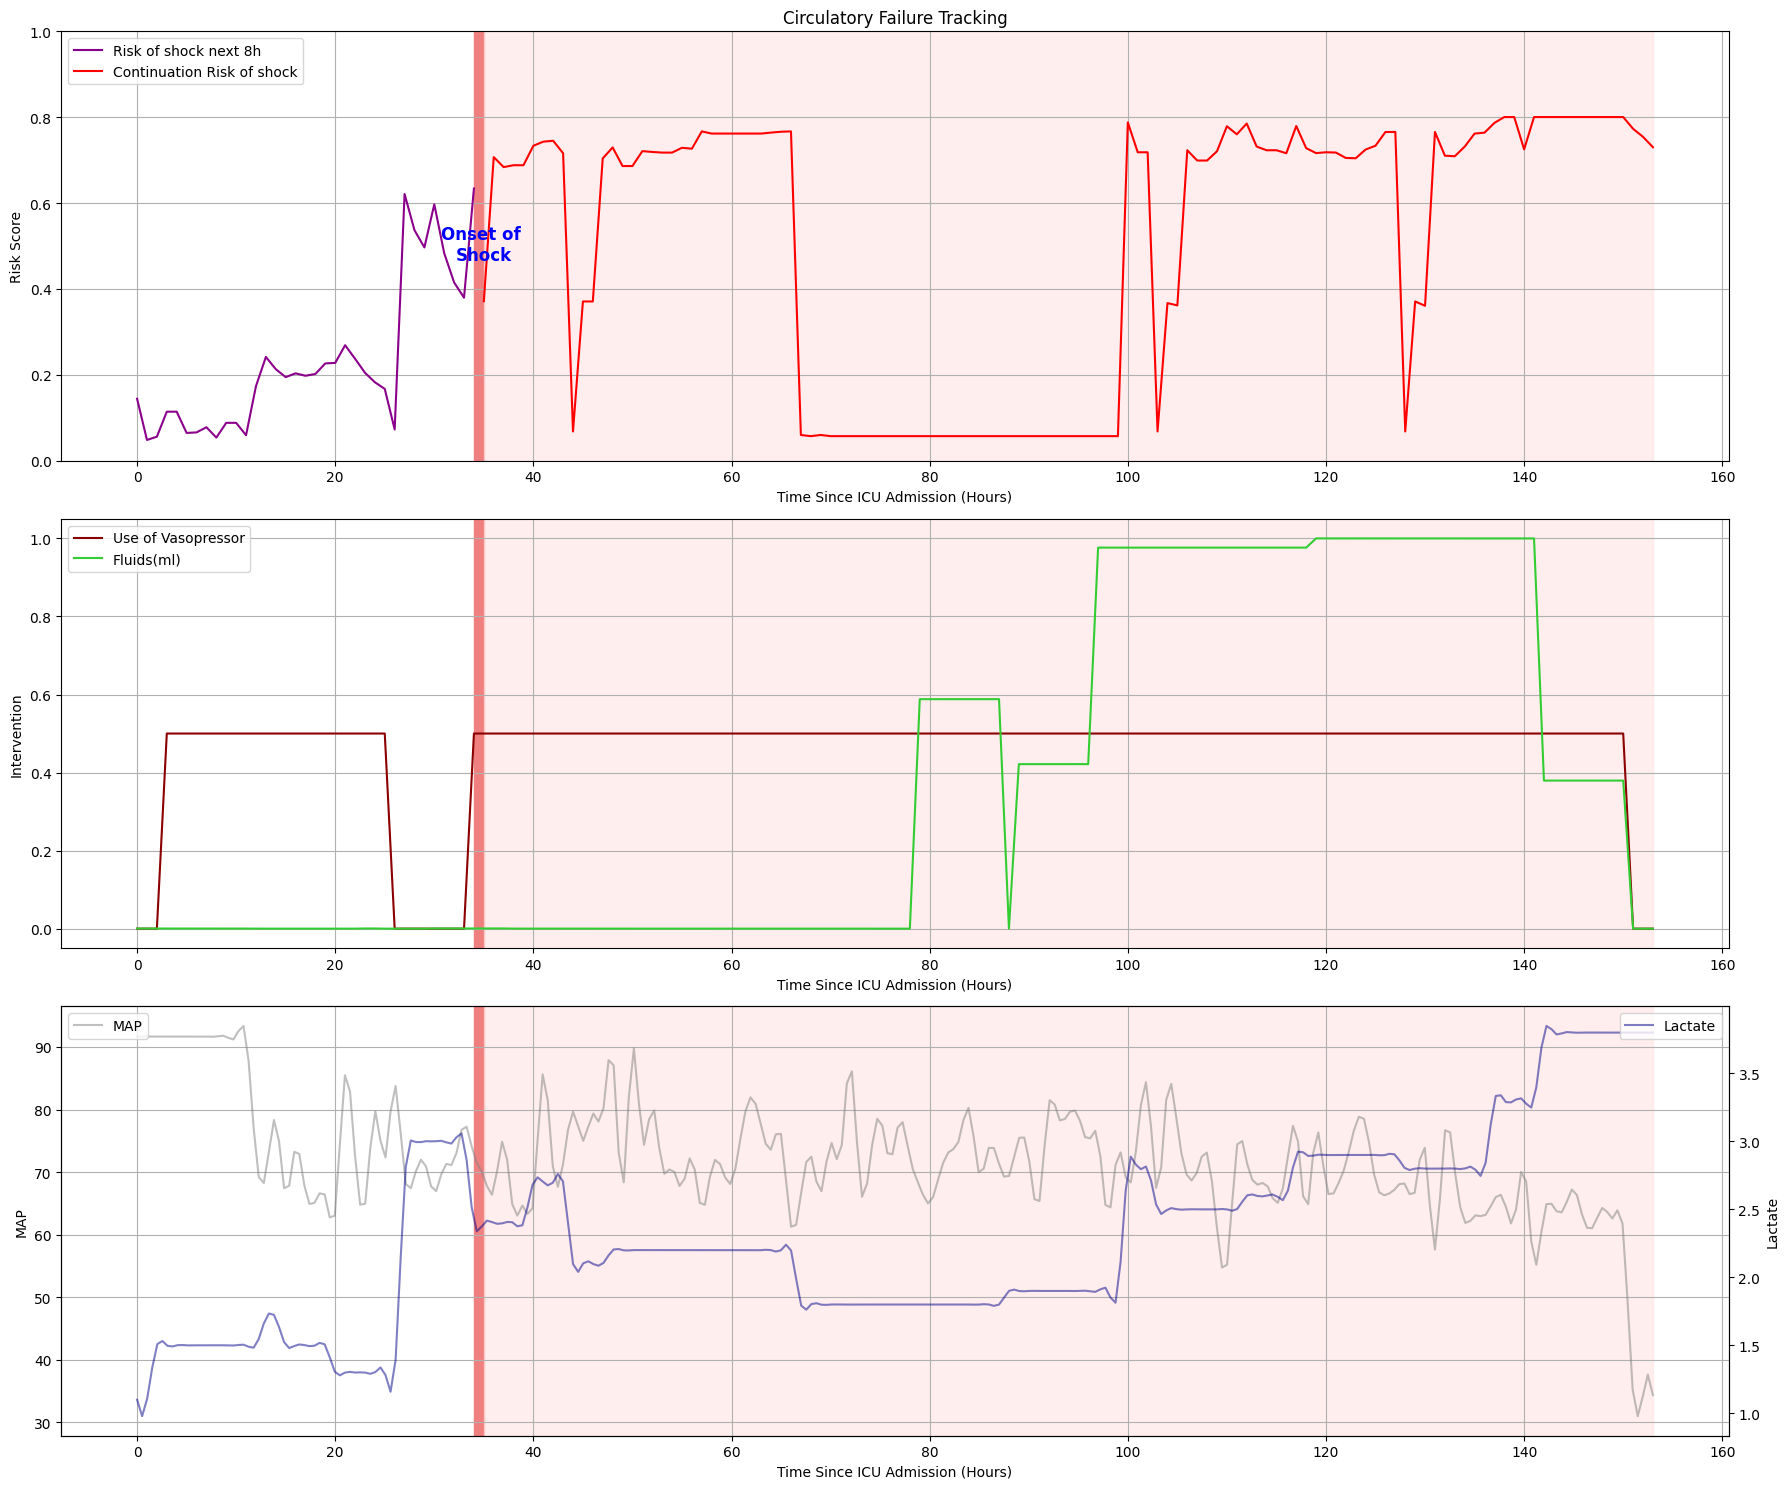

In [39]:
import matplotlib.pyplot as plt
# 0, 1
sec = 1

interest = no_recovery_set[no_recovery_set['stay_id'] == no_viz_id[sec]].reset_index(drop=True)

interest['Fluids(ml)_scaled'], fluids_min, fluids_max = min_max_scaling(interest['Fluids(ml)'], 'none', 'none')
interest['Lactate_scaled'], lactate_min, lactate_max = min_max_scaling(interest['Lactate'], 'none', 'none')
interest['MAP_scaled'], map_min, map_max = min_max_scaling(interest['MAP'], 'none', 'none')

event_index = interest[interest['after_shock_annotation']=='before_experience_shock'].index[-1]

Case1_2 = interest.iloc[:event_index+1]
Case3_4 = interest.iloc[event_index+1:]
Case3_4 = Case3_4.drop_duplicates(subset=['Time_since_ICU_admission'])

onset_of_shock_time = Case3_4['Time_since_ICU_admission'].iloc[0]
end_of_shock_time = Case3_4['Time_since_ICU_admission'].iloc[-1]

# out_of_analysis = eicu_pre[eicu_pre['patientunitstayid'] == no_viz_id[sec]][['Time_since_ICU_admission', 'MAP', 'Lactate', 'vasoactive/inotropic', 'Fluids(ml)']]
out_of_analysis = mimic_pre[mimic_pre['stay_id'] == no_viz_id[sec]][['Time_since_ICU_admission', 'MAP', 'Lactate', 'vasoactive/inotropic', 'Fluids(ml)']]
view = out_of_analysis[(out_of_analysis['Time_since_ICU_admission'] > end_of_shock_time) & (out_of_analysis['Time_since_ICU_admission'] < end_of_shock_time+5)]

view['Fluids(ml)_scaled'] = min_max_scaling(view['Fluids(ml)'], fluids_min, fluids_max)
view['Lactate_scaled'] = min_max_scaling(view['Lactate'],lactate_min, lactate_max)
view['MAP_scaled'] = min_max_scaling(view['MAP'],  map_min, map_max)

fig, ax1 = plt.subplots(3, 1, figsize=(18, 15)) 

# Case1_2
ax1[0].plot(Case1_2['Time_since_ICU_admission'], Case1_2['prediction_prob_case2'], linestyle='-', color='darkmagenta', label='Risk of shock next 8h')
# Case3_4
ax1[0].plot(Case3_4['Time_since_ICU_admission'], Case3_4['prediction_prob_case4'], linestyle='-', color='red', label='Continuation Risk of shock')

ax1[0].axvspan(onset_of_shock_time-1, onset_of_shock_time, color='lightcoral')
ax1[0].axvspan(onset_of_shock_time, end_of_shock_time, color='mistyrose', alpha=0.6)
# ax1[0].axvspan(end_of_shock_time, end_of_shock_time+5, color='lightgreen', alpha=0.4, label = 'Recovery')
# Onset of shock
ax1[0].text(onset_of_shock_time, 0.5 * (Case1_2['prediction_prob_case2'].iloc[-1] + Case3_4['prediction_prob_case4'].iloc[0]), 'Onset of \nShock', ha='center', va='center', fontsize=12, color='blue', fontweight='bold')

# xmin, xmax = 0, interest['Time_since_ICU_admission'].iloc[-1]  
# plt.xticks(range(xmin, xmax + 1, 4))
ymin, ymax = 0, 1 
ax1[0].set_yticks(np.arange(ymin, ymax + 0.1, 0.2))

ax1[0].set_title('Circulatory Failure Tracking')
ax1[0].set_xlabel('Time Since ICU Admission (Hours)')
ax1[0].set_ylabel('Risk Score')
ax1[0].grid(True)
ax1[0].legend(loc = 'upper left')

# Intervention ----------------------------------------------------------------------------------------------------

# fig, ax1 = plt.subplots(3, 1, figsize=(10, 15)) 

vital_lab = pd.concat([interest[view.columns], view.reset_index(drop=True)], axis = 0, ignore_index=True).drop_duplicates(subset=['Time_since_ICU_admission']).sort_values(by=['Time_since_ICU_admission'])

# Case1_2
ax1[1].plot(vital_lab['Time_since_ICU_admission'], (vital_lab['vasoactive/inotropic']/2), linestyle='-', color='darkred', label='Use of Vasopressor')
# Case3_4
ax1[1].plot(vital_lab['Time_since_ICU_admission'], vital_lab['Fluids(ml)_scaled'], linestyle='-', color='limegreen', label='Fluids(ml)')


ax1[1].axvspan(onset_of_shock_time-1, onset_of_shock_time, color='lightcoral')
ax1[1].axvspan(onset_of_shock_time, end_of_shock_time, color='mistyrose', alpha=0.6)
# ax1[1].axvspan(end_of_shock_time, end_of_shock_time+5, color='lightgreen', alpha=0.4, label = 'Recovery')

ax1[1].set_ylabel('Intervention')
ax1[1].set_xlabel('Time Since ICU Admission (Hours)')
ax1[1].grid(True)
ax1[1].legend(loc = 'upper left')

# Vital sign & Lab test--------------------------------------------------------------------------------------------

# fig, ax1 = plt.subplots(3, 1, figsize=(18, 15))
vital_lab = pd.concat([interest[view.columns], view.reset_index(drop=True)], axis = 0, ignore_index=True).drop_duplicates(subset=['Time_since_ICU_admission']).sort_values(by=['Time_since_ICU_admission'])

MAP_before_shock = np.linspace(vital_lab['Time_since_ICU_admission'].min(), vital_lab['Time_since_ICU_admission'].max(), 300) 
spl = make_interp_spline(vital_lab['Time_since_ICU_admission'].values, vital_lab['MAP'].values, k=3) 
power_smooth_map_bs = spl(MAP_before_shock)

Lactate_before_shock = np.linspace(vital_lab['Time_since_ICU_admission'].min(), vital_lab['Time_since_ICU_admission'].max(), 300) 
spl = make_interp_spline(vital_lab['Time_since_ICU_admission'].values, vital_lab['Lactate'].values, k=3) 
power_smooth_lactate_bs = spl(Lactate_before_shock)

ax2 = ax1[2].twinx()  # 이중 y축 생성

# MAP 데이터 플로팅
ax1[2].plot(MAP_before_shock, power_smooth_map_bs, linestyle='-', color='gray', label='MAP', alpha=0.5)
ax1[2].set_ylabel('MAP', color='Black')
ax1[2].tick_params(axis='y', labelcolor='Black')  # 변경: axis 지정 방식

# Lactate 데이터 플로팅
ax2.plot(Lactate_before_shock, power_smooth_lactate_bs, linestyle='-', color='darkblue', label='Lactate', alpha=0.5)
ax2.set_ylabel('Lactate', color='Black')
ax2.tick_params(axis='y', labelcolor='Black')  # 변경: axis 지정 방식

# 충격과 회복 기간 표시
ax1[2].axvspan(onset_of_shock_time-1, onset_of_shock_time, color='lightcoral')
ax1[2].axvspan(onset_of_shock_time, end_of_shock_time, color='mistyrose', alpha=0.6)
# ax1[2].axvspan(end_of_shock_time, end_of_shock_time+5, color='lightgreen', alpha=0.4, label='Recovery')

ax1[2].set_xlabel('Time Since ICU Admission (Hours)')
ax1[2].grid(True)
ax1[2].legend(loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()

In [43]:
interest.head(60)

,stay_id,Time_since_ICU_admission,vasoactive/inotropic,Fluids(ml),Annotation,after_shock_annotation,Case,INDEX,Lactate,MAP,prediction_label,prediction_prob_case2,prediction_prob_case3,prediction_prob_case4,Fluids(ml)_scaled,Lactate_scaled,MAP_scaled
0,31374882,0,0,771.085269,no_circ,before_experience_shock,1,CASE1_CASE2_DF,1.1,91.666667,1.0,0.144091,0.064656,0.066105,0.000322,0.000000,1.000000
1,31374882,1,0,771.085269,no_circ,before_experience_shock,1,CASE1_CASE2_DF,1.1,91.666667,1.0,0.048132,0.051678,0.052837,0.000322,0.000000,1.000000
2,31374882,2,0,771.085269,no_circ,before_experience_shock,1,CASE1_CASE2_DF,1.5,91.666667,1.0,0.055704,0.051267,0.052417,0.000322,0.148148,1.000000
3,31374882,3,1,711.442806,ambiguous,before_experience_shock,1,CASE1_CASE2_DF,1.5,91.666667,1.0,0.113963,0.060511,0.061868,0.000297,0.148148,1.000000
4,31374882,4,1,711.442806,ambiguous,before_experience_shock,1,CASE1_CASE2_DF,1.5,91.666667,1.0,0.113963,0.060511,0.061868,0.000297,0.148148,1.000000
5,31374882,5,1,711.442806,ambiguous,before_experience_shock,1,CASE1_CASE2_DF,1.5,91.666667,1.0,0.064519,0.050789,0.051927,0.000297,0.148148,1.000000
6,31374882,6,1,723.295546,ambiguous,before_experience_shock,1,CASE1_CASE2_DF,1.5,91.666667,1.0,0.065674,0.051408,0.052560,0.000302,0.148148,1.000000
7,31374882,7,1,538.158219,ambiguous,before_experience_shock,1,CASE1_CASE2_DF,1.5,91.666667,1.0,0.077816,0.052374,0.053548,0.000225,0.148148,1.000000
8,31374882,8,1,538.158219,ambiguous,before_experience_shock,1,CASE1_CASE2_DF,1.5,91.666667,1.0,0.053608,0.052072,0.053239,0.000225,0.148148,1.000000
9,31374882,9,1,538.158219,ambiguous,before_experience_shock,1,CASE1_CASE2_DF,1.5,91.666667,1.0,0.088022,0.054308,0.055525,0.000225,0.148148,1.000000
